In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely as shp

import importlib
from tqdm import tqdm

import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
import st_toolkit as geohl
importlib.reload(geohl)

import cri_calc as cri
importlib.reload(cri)

import cri_helper as helper
importlib.reload(helper)

import encounters
importlib.reload(encounters)

<module 'encounters' from '/Users/andrewt/Documents/Univ. Piraeus Research Center/VCRA/encounters.py'>

In [3]:
def get_arrow(angle):
    a = np.deg2rad(angle)
    ar = np.array([[-.25,-.5],[.25,-.5],[0,.5],[-.25,-.5]]).T
    rot = np.array([[np.cos(a),np.sin(a)],[-np.sin(a),np.cos(a)]])
    return np.dot(rot,ar).T

# Load Data

In [4]:
SRC_PATH = './data/norway-dataset/oslo_jan_mar_2019_4w_prep_algn_linear_v2_w_lens.vcrf_output_v4.pkl'

gdf = pd.read_pickle(SRC_PATH)
gdf = gdf.loc[gdf.datetime.between('2019-01-01', '2019-01-28', inclusive='left')].copy()

In [5]:
gdf.loc[:, 'disp_err'] = np.linalg.norm([gdf['lon_actual'] - gdf['lon_pred'], gdf['lat_actual'] - gdf['lat_pred']], axis=0)

In [6]:
gdf.sort_values(['mmsi', 'timestamp', 'disp_err'], inplace=True)
gdf.duplicated(subset=['mmsi', 'datetime']).any()

True

In [7]:
gdf.drop_duplicates(subset=['mmsi', 'datetime'], keep='first', inplace=True)

In [8]:
gdf_actual = gdf[['mmsi', 'traj_nr', 'timestamp', 'datetime', 'lon_actual', 'lat_actual', 'speed_actual', 'course_actual', 'length']].copy()
gdf_actual = gpd.GeoDataFrame(
    gdf_actual, crs=3035, geometry=gpd.points_from_xy(gdf_actual['lon_actual'], gdf_actual['lat_actual'])
).to_crs(4326)

In [9]:
gdf_pred = gdf[['mmsi', 'traj_nr', 'timestamp', 'datetime', 'lon_pred', 'lat_pred', 'speed_pred', 'course_pred', 'length']].copy()
gdf_pred = gpd.GeoDataFrame(
    gdf_pred, crs=3035, geometry=gpd.points_from_xy(gdf_pred['lon_pred'], gdf_pred['lat_pred'])
).to_crs(4326)

In [10]:
# OUTPUT ONLY
gdf_actual.rename(
    {
        'lon_actual':'lon',
        'lat_actual':'lat',
        'speed_actual':'speed',
        'course_actual':'course'
    }, 
    axis=1, inplace=True
)

gdf_pred.rename(
    {
        'lon_pred':'lon',
        'lat_pred':'lat',
        'speed_pred':'speed',
        'course_pred':'course'
    }, 
    axis=1, inplace=True
)

# Get vessels' locations with speed s: s < 50 knots
gdf_actual = gdf_actual.loc[gdf_actual.speed < 50].sort_values('datetime').copy()
gdf_pred = gdf_pred.loc[gdf_actual.speed < 50].sort_values('datetime').copy()

# Adjust ```lat``` and ```lon``` columns to reflect EPSG:4326 
gdf_actual.loc[:, ['lon', 'lat']] = pd.concat([gdf_actual.geometry.x, gdf_actual.geometry.y], axis=1, keys=['lon', 'lat'])
gdf_pred.loc[:, ['lon', 'lat']] = pd.concat([gdf_pred.geometry.x, gdf_pred.geometry.y], axis=1, keys=['lon', 'lat'])

### Visualizing a Random Trajectory

In [ ]:
m = gdf_actual.loc[gdf_actual.mmsi == 538006805].astype({'datetime':str}).explore(color='blue')
gdf_pred.loc[gdf_pred.mmsi == 538006805].astype({'datetime':str}).explore(m=m, color='magenta')

# Compare ```Actual``` vs. ```Predicted``` encounters

In [11]:
vcra_model = pd.read_pickle('./data/pickle/vcra_skf_results_df.cart_vs_mlp.trained_on_all_data_v14.pickle').xs(('mlp_vcra', 1))['instance']

In [12]:
active_pairs_actual, inactive_pairs_actual, results_actual = encounters.encountering_vessels(
    gdf_actual,
    merge_output=False
)

Prior: len(active_pairs)=0, len(inactive_pairs)=0, len(results)=0


100%|████████████████████████████████████████████████████████████████| 40216/40216 [01:35<00:00, 419.22it/s]


In [13]:
active_pairs_pred, inactive_pairs_pred, results_pred = encounters.encountering_vessels(
    gdf_pred,
    merge_output=False,
    vcra_model=vcra_model
)

Prior: len(active_pairs)=0, len(inactive_pairs)=0, len(results)=0


100%|████████████████████████████████████████████████████████████████| 40216/40216 [01:34<00:00, 426.97it/s]


In [14]:
active_pairs_actual.shape, inactive_pairs_actual.shape, results_actual.shape

((0, 6), (36, 6), (328, 27))

In [15]:
active_pairs_pred.shape, inactive_pairs_pred.shape, results_pred.shape

((0, 6), (26, 6), (126, 27))

## Comparing ```Actual``` vs. ```Pred``` encounters

In [19]:
inactive_pairs_actual.head()

,dist,start,end,geometry,kinematics_own,kinematics_target
pair,,,,,,
"(231522000.0, 255805984.0)",928.435086,2019-01-07 16:52:30,2019-01-07 16:54:30,"[[10.648259317640338, 59.194263392533706], [10...",mmsi ...,mmsi ...
"(255805984.0, 231522000.0)",928.435086,2019-01-07 16:52:30,2019-01-07 16:54:30,"[[10.627627315912427, 59.206327272206], [10.62...",mmsi ...,mmsi ...
"(305115000.0, 314262000.0)",1139.857454,2019-01-07 21:54:00,2019-01-07 21:55:30,"[[10.621490046766096, 59.22314999953751], [10....",mmsi ...,mmsi ...
"(314262000.0, 305115000.0)",1139.857454,2019-01-07 21:54:00,2019-01-07 21:55:30,"[[10.645258342547258, 59.212658331894374], [10...",mmsi ...,mmsi ...
"(244850970.0, 258168000.0)",966.896498,2019-01-08 02:47:30,2019-01-08 02:49:30,"[[10.58196168415668, 59.33034444303331], [10.5...",mmsi ...,mmsi ...


In [20]:
inactive_pairs_pred.head()

,dist,start,end,geometry,kinematics_own,kinematics_target
pair,,,,,,
"(277400000.0, 314260000.0)",1651.601569,2019-01-07 15:38:30,2019-01-07 15:39:30,"[[10.709598536306396, 59.00451195099566], [10....",mmsi ...,mmsi ...
"(314260000.0, 277400000.0)",1651.601569,2019-01-07 15:38:30,2019-01-07 15:39:30,"[[10.70349859869253, 59.02037749409931], [10.7...",mmsi ...,mmsi ...
"(231522000.0, 255805984.0)",960.951710,2019-01-07 16:52:00,2019-01-07 16:54:00,"[[10.647765194113617, 59.19627653951183], [10....",mmsi ...,mmsi ...
"(255805984.0, 231522000.0)",960.951710,2019-01-07 16:52:00,2019-01-07 16:54:00,"[[10.627518380249805, 59.20700506407872], [10....",mmsi ...,mmsi ...
"(305115000.0, 314262000.0)",1188.553723,2019-01-07 21:54:30,2019-01-07 21:56:00,"[[10.621293371018602, 59.22141614326365], [10....",mmsi ...,mmsi ...


In [21]:
actual_vs_pred = inactive_pairs_actual.join(
    inactive_pairs_pred,
    how='inner', 
    lsuffix='_actual', 
    rsuffix='_pred'
)

actual_vs_pred = actual_vs_pred.loc[(actual_vs_pred.start_pred <= actual_vs_pred.end_actual) & (actual_vs_pred.start_actual <= actual_vs_pred.end_pred)].copy()

In [22]:
actual_vs_pred.shape

(24, 12)

# Conclusions:
## 2 false positives (predicted encounters that did not happened)
## 12 false negatives (actual encounters that were not discovered)

In [23]:
def temporal_jaccard(a, b, c, d):
    return (abs(c - b)).total_seconds() / (max(b, d) - min(a, c)).total_seconds()

In [24]:
actual_vs_pred.loc[:, 'temp_sim'] = actual_vs_pred.apply(lambda l: temporal_jaccard(l.start_actual, l.end_actual, l.start_pred, l.end_pred), axis=1)

In [25]:
actual_vs_pred.temp_sim.describe()

count    24.000000
mean      0.766363
std       0.352130
min       0.019608
25%       0.764706
50%       0.933333
75%       1.000000
max       1.000000
Name: temp_sim, dtype: float64

# Visualizing on the Map

In [26]:
CFG_PRODUCER_KEY, CFG_PRODUCER_TIMESTAMP_UNIT, CFG_DATASET_CRS = 'mmsi', None, 4326


def process_encountering_processes(encountering_pairs, vcra_results):
    # Add CRI Information
    encountering_pairs.loc[:, 'ves_cri'] = encountering_pairs.apply(
        lambda l: vcra_results.loc[
            pd.IndexSlice[l.start:l.end, :]
        ].loc[
            (vcra_results[f'own_{CFG_PRODUCER_KEY}'] == l.pair[0]) & 
            (vcra_results[f'target_{CFG_PRODUCER_KEY}'] == l.pair[1])
        ].ves_cri.mean(), 
        axis=1
    )
    
    # Parse Geometry, and Start/End timestamps 
    encountering_pairs.geometry = encountering_pairs.geometry.apply(lambda x: shp.geometry.LineString(x))
    encountering_pairs.start = pd.to_datetime(encountering_pairs.start, unit=CFG_PRODUCER_TIMESTAMP_UNIT)
    encountering_pairs.end = pd.to_datetime(encountering_pairs.end, unit=CFG_PRODUCER_TIMESTAMP_UNIT)

    return gpd.GeoDataFrame(encountering_pairs, geometry='geometry', crs=CFG_DATASET_CRS)

In [27]:
dataset_actual = process_encountering_processes(
    pd.concat((active_pairs_actual, inactive_pairs_actual)).reset_index(drop=False), 
    results_actual.copy()
)

In [28]:
dataset_pred = process_encountering_processes(
    pd.concat((active_pairs_pred, inactive_pairs_pred)).reset_index(drop=False), 
    results_pred.copy()
)

  * ### Creating Choropleth (Grid) Geometry

In [29]:
def generate_spatial_grid(bbox, crs_from=4326, cells_no=10):
    spatial_coverage = gpd.GeoSeries(shp.geometry.box(*bbox), index=['geom'], crs=crs_from).to_crs(3857)
    
    # Calculate cutoff value, according to ```cells_no```
    cutoff_pnt = np.around(
        np.mean([
            np.diff(spatial_coverage.total_bounds[[0, -2]]) / cells_no,\
            np.diff(spatial_coverage.total_bounds[[1, -1]]) / cells_no
        ]),
    )
    
    # Generate Spatial Grid
    return cri.stt.create_area_grid(spatial_coverage[0], crs=3857, quadrat_width=cutoff_pnt)

In [30]:
mbb_dataset = pd.DataFrame(np.vstack((gdf_actual.total_bounds, gdf_pred.total_bounds))).agg({0:min, 1:min, 2:max, 3:max}).round(5).values.tolist()
spatial_coverage_cut = generate_spatial_grid(mbb_dataset, crs_from=4326, cells_no=30)

  * ### Classifying Area Proximity (i.e., Populate the Choropleth Map)

In [31]:
def mean_cri_per_cell(spatial_grid, geoms, crs_to=3857):
    sindex = spatial_grid.sindex
    
    ix, area_id = sindex.query(geoms.to_crs(crs_to).geometry, predicate='intersects', sort=True)
    geoms.loc[ix, 'area_id'] = area_id
    
    spatial_grid.loc[:, 'mean_cri'] = pd.merge(
        spatial_grid.reset_index(), 
        geoms[['area_id', 'ves_cri']], 
        left_on='index', right_on='area_id', 
        how='left'
    ).groupby('index').ves_cri.mean()
    
    return spatial_grid

In [32]:
spatial_coverage_cut_actual = mean_cri_per_cell(spatial_coverage_cut.copy(), dataset_actual.copy())
spatial_coverage_cut_pred   = mean_cri_per_cell(spatial_coverage_cut.copy(), dataset_pred.copy())

# Visualizing Result

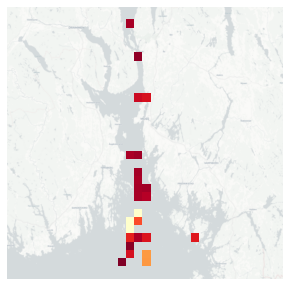

In [33]:
fig, ax = plt.subplots(1,1, figsize=(15,5))

spatial_coverage_cut_actual.plot(column='mean_cri', cmap='YlOrRd', ax=ax)
ax.set_xlim(*np.array(ax.get_xlim()) + [-80000, 60000])
ctx.add_basemap(ax, attribution='', source=ctx.providers.CartoDB.Positron)

ax.axis('off')
plt.savefig('traffic_flow_cri_actual.png', dpi=300, bbox_inches='tight')

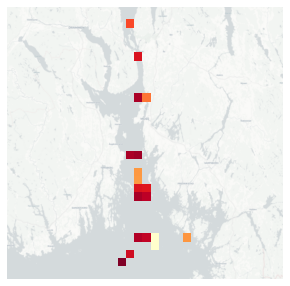

In [34]:
fig, ax2 = plt.subplots(1,1, figsize=(15,5))

spatial_coverage_cut_pred.plot(column='mean_cri', cmap='YlOrRd', ax=ax2)
ax2.set_xlim(*ax.get_xlim())
ctx.add_basemap(ax2, attribution='', source=ctx.providers.CartoDB.Positron)

ax2.axis('off')
plt.savefig('traffic_flow_cri_pred.png', dpi=300, bbox_inches='tight')

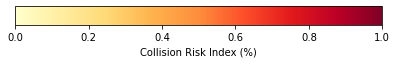

In [37]:
# draw a new figure and replot the colorbar there
fig, cax = plt.subplots(figsize=(7,3))
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=0, vmax=1))

# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, orientation='horizontal', shrink=0.94, pad=0.02, ax=cax)
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_xlabel(r'Collision Risk Index (%)', fontsize=10, labelpad=5)

cax.remove()
cbar.ax.tick_params(labelsize=10)
cbar.ax.xaxis.set_ticks_position("bottom")
plt.savefig('colorbar.png', dpi=300, bbox_inches='tight')